In [9]:
import os
import pickle
from typing import Optional

import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from transformers.modelcard import parse_log_history

In [10]:
##### INPUTS #####
dataset_name = "race_pp_4000"
seed = 123
model_name = "DistilBERT"
encoding = "question_all"

## Test metrics

In [11]:
def get_metrics(dataset_name: str, model_name: str, encoding: Optional[str], seed: Optional[int], init: bool = False) -> pd.DataFrame:
    """Read metrics from output directory and return as a dataframe."""
    if seed is None:
        output_dir = os.path.join('output', dataset_name)
    else:
        output_dir = os.path.join('output', dataset_name, 'seed_' + str(seed))

    init_str = "_init" if init else ""
    encoding_str = f"_{encoding}" if encoding is not None else ""
    read_path = os.path.join(output_dir, f"eval_metrics_{model_name}{encoding_str}{init_str}.csv")
    print(f"reading path: '{read_path}'")
    
    metrics = pd.read_csv(read_path)
    metrics = metrics.transpose().reset_index().rename(columns={'index': 'metric', 0: 'value'})
    return metrics

### Before training

In [12]:
metrics_init = get_metrics(dataset_name, model_name, encoding, seed, init=True)
metrics_init

reading path: 'output/race_pp_4000/seed_123/eval_metrics_DistilBERT_question_all_init.csv'


,metric,value
0,test_mean_absolute_error,0.870968
1,train_mean_absolute_error,1.000000
2,test_root_mean_squared_error,1.059218
3,train_root_mean_squared_error,1.290994
4,test_r2_score,-2.087708
5,train_r2_score,-1.500000
6,test_spearman_rho,NaN
7,train_spearman_rho,NaN
8,test_pearson_rho,NaN
9,train_pearson_rho,NaN


### After training

In [13]:


metrics = get_metrics(dataset_name, model_name, encoding, seed, init=False)
metrics

reading path: 'output/race_pp_4000/seed_123/eval_metrics_DistilBERT_question_all.csv'


,metric,value
0,test_mean_absolute_error,0.233428
1,train_mean_absolute_error,0.120280
2,test_root_mean_squared_error,0.493668
3,train_root_mean_squared_error,0.354657
4,test_r2_score,0.329289
5,train_r2_score,0.811328
6,test_spearman_rho,0.694912
7,train_spearman_rho,0.908163
8,test_pearson_rho,0.705740
9,train_pearson_rho,0.907741


## Training logs

In [14]:
def get_train_logs(dataset_name: str, model_name: str, encoding: str, seed: int) -> tuple:
    """Read training logs from output directory and return as a dictionary."""
    output_dir = os.path.join('output', dataset_name, 'seed_' + str(seed))

    with open(os.path.join(output_dir, model_name + '_' + encoding, "train_logs.pickle"), 'rb') as handle:
        logs = pickle.load(handle)
    train_log, lines, eval_results = parse_log_history(logs)  # NOTE: func from transformers.modelcard
    return train_log, lines, eval_results

train_log, lines, eval_results = get_train_logs(dataset_name, model_name, encoding, seed)

print("="*3, "train_log", "="*3)
pprint(train_log)
print("="*3, "lines", "="*3)
pprint(lines)
print("="*3, "eval_results", "="*3)
pprint(eval_results)

=== train_log ===
{'epoch': 3.0,
 'step': 750,
 'total_flos': 794591520173568.0,
 'train_loss': 0.19100984191894532,
 'train_runtime': 321.9103,
 'train_samples_per_second': 37.268,
 'train_steps_per_second': 2.33}
=== lines ===
[{'Epoch': 0.2,
  'R Squared': 0.268,
  'Rmse': 0.5182340741157532,
  'Step': 50,
  'Training Loss': 'No log',
  'Validation Loss': 0.2685665786266327},
 {'Epoch': 0.4,
  'R Squared': 0.408,
  'Rmse': 0.4659760296344757,
  'Step': 100,
  'Training Loss': 'No log',
  'Validation Loss': 0.21713370084762573},
 {'Epoch': 0.6,
  'R Squared': 0.478,
  'Rmse': 0.43772459030151367,
  'Step': 150,
  'Training Loss': 'No log',
  'Validation Loss': 0.19160281121730804},
 {'Epoch': 0.8,
  'R Squared': 0.457,
  'Rmse': 0.44617772102355957,
  'Step': 200,
  'Training Loss': 'No log',
  'Validation Loss': 0.19907455146312714},
 {'Epoch': 1.0,
  'R Squared': 0.531,
  'Rmse': 0.41480082273483276,
  'Step': 250,
  'Training Loss': 'No log',
  'Validation Loss': 0.172059714794158

In [15]:
def remove_nesting(logs: list[dict[str, float]]) -> list[dict[str, float]]:
    """Remove unnecessary nesting from logs."""
    new_logs = []
    for log_epoch in logs:
        tmp_dict = {}
        for key, value in log_epoch.items():
            if isinstance(value, dict):
                nested_keys = list(value.keys())
                if len(nested_keys) == 1 and key.lower() == nested_keys[0]:
                    tmp_dict[key] = value[nested_keys[0]]
            else:
                tmp_dict[key] = value
        new_logs.append(tmp_dict)
    return new_logs


all_logs = remove_nesting(lines)
pprint(all_logs)

[{'Epoch': 0.2,
  'R Squared': 0.268,
  'Rmse': 0.5182340741157532,
  'Step': 50,
  'Training Loss': 'No log',
  'Validation Loss': 0.2685665786266327},
 {'Epoch': 0.4,
  'R Squared': 0.408,
  'Rmse': 0.4659760296344757,
  'Step': 100,
  'Training Loss': 'No log',
  'Validation Loss': 0.21713370084762573},
 {'Epoch': 0.6,
  'R Squared': 0.478,
  'Rmse': 0.43772459030151367,
  'Step': 150,
  'Training Loss': 'No log',
  'Validation Loss': 0.19160281121730804},
 {'Epoch': 0.8,
  'R Squared': 0.457,
  'Rmse': 0.44617772102355957,
  'Step': 200,
  'Training Loss': 'No log',
  'Validation Loss': 0.19907455146312714},
 {'Epoch': 1.0,
  'R Squared': 0.531,
  'Rmse': 0.41480082273483276,
  'Step': 250,
  'Training Loss': 'No log',
  'Validation Loss': 0.17205971479415894},
 {'Epoch': 1.2,
  'R Squared': 0.525,
  'Rmse': 0.4173191785812378,
  'Step': 300,
  'Training Loss': 'No log',
  'Validation Loss': 0.17415529489517212},
 {'Epoch': 1.4,
  'R Squared': 0.566,
  'Rmse': 0.3989850878715515,
 

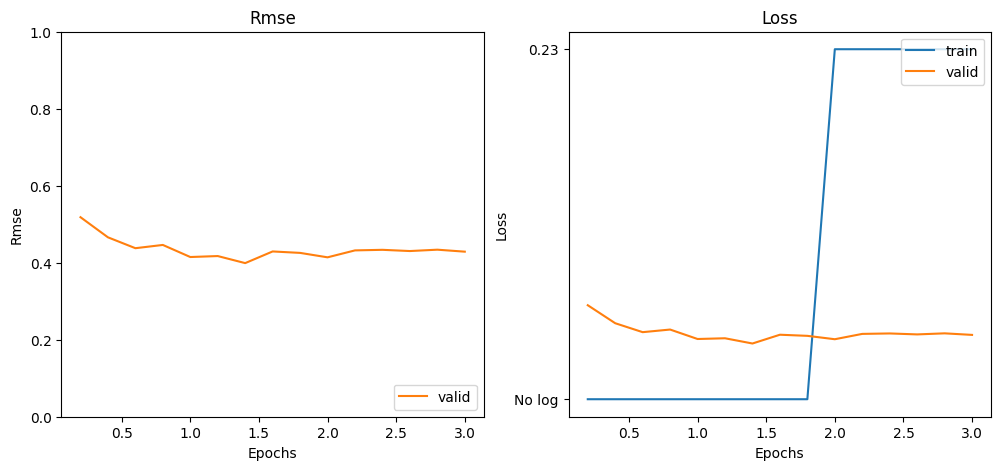

In [16]:
def plot_history(all_logs: list[dict[str, float]], metric: str) -> None:
    """Plot metric and loss in function of number of epochs.
    Parameters
    ----------
    all_logs : list[dict[str, float]]
        List of dictionaries containing the training logs for each epoch.
    metric : str
        Metric to plot (in addition to loss).
    """
    
    epochs_arr = [log_epoch['Epoch'] for log_epoch in all_logs]
    train_loss_arr = [log_epoch['Training Loss'] for log_epoch in all_logs]
    val_loss_arr = [log_epoch['Validation Loss'] for log_epoch in all_logs]
    metric_arr = [log_epoch[metric] for log_epoch in all_logs]

    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs_arr, metric_arr, color="tab:orange")
    plt.ylim(0, 1)
    plt.title(metric)
    plt.ylabel(metric)
    plt.xlabel('Epochs')
    plt.legend(['valid'], loc='lower right')

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs_arr, train_loss_arr)
    plt.plot(epochs_arr, val_loss_arr)
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'valid'], loc='upper right')

    plt.show()

# metric = "R Squared"
metric = "Rmse"
plot_history(all_logs, metric)